In [2]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2")

/usr/local/python/3.12.1/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/python/3.12.1/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
from elasticsearch import Elasticsearch, helpers

es_client = Elasticsearch("http://127.0.0.1:9200")
es_client.info()

ObjectApiResponse({'name': 'fe83fe2e7fcb', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'cZLx_uzYTWKP70UA0Rgk7g', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

### Create user query for searching in ES (vector search)

In [8]:
# User query:
question = "tell me about abduction"
question_vectorized = model.encode(question)

In [11]:
knn_query = {
    "field": "vector_sectionPath_content",
    "query_vector": question_vectorized,
    "k": 7,
    "num_candidates": 10000, 
}
index_name = "philosophy"

In [12]:
knn_res = es_client.search(index=index_name, knn=knn_query, source=["chunk_id", "article_title", "content"])
knn_res["hits"]["hits"]

[{'_index': 'philosophy',
  '_id': '8499745946def21e570ae45e9a8b2a82',
  '_score': 0.8652704,
  '_source': {'article_title': 'Abduction',
   'chunk_id': '8499745946def21e570ae45e9a8b2a82',
   'content': '\nIn textbooks on epistemology or the philosophy of science, one often\nencounters something like the following as a formulation of\nabduction:'}},
 {'_index': 'philosophy',
  '_id': '81e573a9d329de10a9651c19c4907dc2',
  '_score': 0.84667337,
  '_source': {'article_title': 'Abduction',
   'chunk_id': '81e573a9d329de10a9651c19c4907dc2',
   'content': '\nYou happen to know that Tim and Harry have recently had a terrible row\nthat ended their friendship. Now someone tells you that she just saw\nTim and Harry jogging together. The best explanation for this that you\ncan think of is that they made up. You conclude that they are friends\nagain.'}},
 {'_index': 'philosophy',
  '_id': 'a769e7233c923d5482ef84a18d34e322',
  '_score': 0.8429227,
  '_source': {'article_title': 'Abduction',
   'chu

`TODO`chuncking via paragraphs переносит важную информацию с ответом на вопрос в следующий параграф 

### Keyword search with Semantic Search (Hybrid/Advanced Search)

In [11]:
def elastic_search_hybrid1(question):
    question_vectorized = model.encode(question)
    index_name = 'philosophy'
    hybryd_response1 = es_client.search(
        index=index_name,
        query={
            "match": {"article_title": question},
        },
        knn= {
            "field": "vector_sectionPath_content",
            "query_vector": question_vectorized,
            "k": 7,
            "num_candidates": 10000, 
        },
        size=7,
        source=["chunk_id", "article_title", "content"]
    )
    return hybryd_response1

In [15]:
response = elastic_search_hybrid1(question)
response["hits"]["hits"][0]['_source']['content']

'\nIn textbooks on epistemology or the philosophy of science, one often\nencounters something like the following as a formulation of\nabduction:'

todo
```python
def elastic_search_hybrid2(question):
    hybrid_response2 = es_client.search(
        index=index_name,
        body={  # 'body' keyword to define the query structure
            "query": {
                "bool": {
                    "must": [knn_query],  
                    "should": [
                        {"match": {"article_title": question}},
                        {"match": {"concepts": question}},
                        {"match": {"philosophers": question}}
                    ],
                    "minimum_should_match": 1
                }
            },
            "size": 7,
            "_source": ["chunk_id", "article_title", "concepts", "philosophers", "content"]
        }
    )

response = elastic_search_hybrid2(question)
response["hits"]["hits"][0]['_source']['content']
```

# Evaluation

Evaluating:   0%|          | 0/500 [00:00<?, ?it/s]

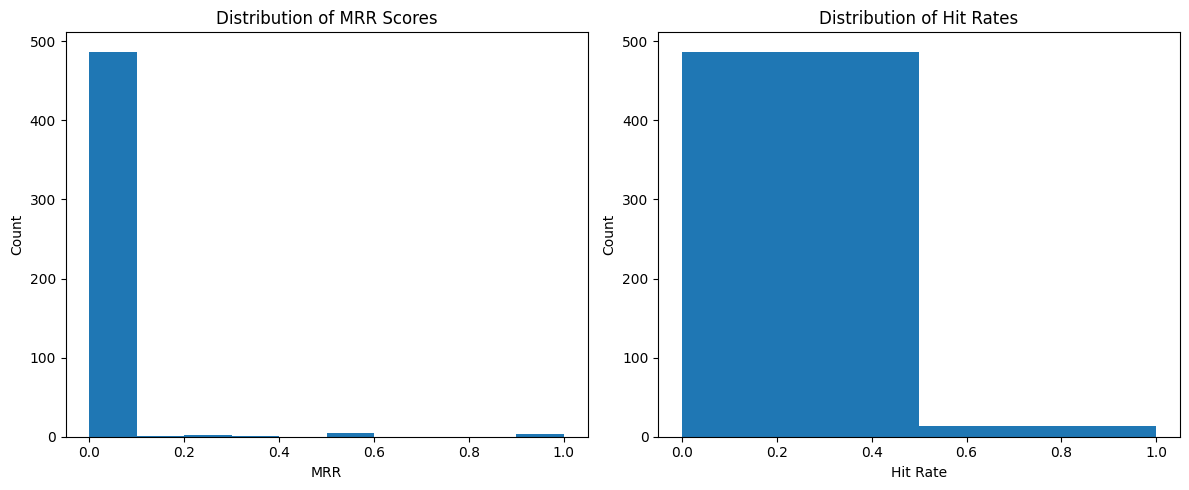

Mean MRR: 0.0149
Mean Hit Rate @ 5: 0.0260


In [49]:
# Evaluation of Philosophical RAG System

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from elasticsearch import Elasticsearch
from tqdm.notebook import tqdm
from datasets import load_dataset
import matplotlib.pyplot as plt

# Initialize necessary components
index_name = "philosophy"

# Load and prepare the dataset
def prepare_evaluation_dataset():
    dataset = load_dataset("ruggsea/stanford-encyclopedia-of-philosophy_instruct", split="train")
    
    # Create ground truth pairs
    eval_pairs = []
    for item in dataset:
        question = item['question']
        answer = item['answer']
        
        # Extract relevant chunks from the answer
        # In a real scenario, you might need more sophisticated chunking
        chunks = [answer[i:i+500] for i in range(0, len(answer), 500)]
        
        eval_pairs.append({
            'question': question,
            'relevant_chunks': chunks
        })
    
    return eval_pairs[:500]  # Limit to 500 for faster evaluation

def calculate_mrr(retrieved_chunks, relevant_chunks):
    for i, chunk in enumerate(retrieved_chunks, 1):
        if any(relevant in chunk['content'] for relevant in relevant_chunks):
            return 1 / i
    return 0

def calculate_hit_rate(retrieved_chunks, relevant_chunks, k=7):
    for chunk in retrieved_chunks[:k]:
        if any(relevant in chunk['content'] for relevant in relevant_chunks):
            return 1
    return 0

def evaluate_retrieval():
    eval_pairs = prepare_evaluation_dataset()
    mrr_scores = []
    hit_rates = []
    
    for pair in tqdm(eval_pairs, desc="Evaluating"):
        results = elastic_search(pair['question'])
        retrieved_chunks = [hit['_source'] for hit in results['hits']['hits']]
        
        mrr = calculate_mrr(retrieved_chunks, pair['relevant_chunks'])
        hit_rate = calculate_hit_rate(retrieved_chunks, pair['relevant_chunks'])
        
        mrr_scores.append(mrr)
        hit_rates.append(hit_rate)
    
    return {
        'mean_mrr': np.mean(mrr_scores),
        'mean_hit_rate': np.mean(hit_rates),
        'mrr_scores': mrr_scores,
        'hit_rates': hit_rates
    }

# Run evaluation
results = evaluate_retrieval()

# Visualize results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(results['mrr_scores'], bins=10)
plt.title('Distribution of MRR Scores')
plt.xlabel('MRR')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(results['hit_rates'], bins=2)
plt.title('Distribution of Hit Rates')
plt.xlabel('Hit Rate')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print(f"Mean MRR: {results['mean_mrr']:.4f}")
print(f"Mean Hit Rate @ 5: {results['mean_hit_rate']:.4f}")

I think such a low result may be related not only to the quality of the answers, but above all to the fact that we did not index the entire dataset (many questions from the dataset cannot be answered by definition).

# LLM using (Groq), RAG flow

Register in Groq, get API_KEY, set it to env:

```bash
export GROQ_API_KEY=<your-api-key-here>
pip install groq
```

In [17]:
import os
os.environ.get("GROQ_API_KEY")

In [18]:
from groq import Groq

client = Groq(
    api_key=api_key=os.environ.get("GROQ_API_KEY"),
)

In [5]:
def build_prompt(query, search_results):
    prompt_template = """
You are an intellectual assistant specializing in philosophy. Your task is to help users find and interpret philosophical concepts and ideas using information from the provided texts. 

Answer the QUESTION based on the CONTEXT from the philosophy database.

Provide a response that is understandable and recreates the historical, intellectual, or social context in which the concept was created if the question concerns a concept. 
If the question concerns a thinker, describe their general teaching, core ideas, and influence on philosophy.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()
    
    context = ""
    for hit in search_results['hits']['hits']:
        context += f"{hit['_source']['content']}\n"
        
    prompt = prompt_template.format(question=query, context=context).strip()
    print(prompt)
    return prompt

def llm(prompt):
    response = client.chat.completions.create(
    messages=[{"role": "user", "content": prompt,}], model="llama3-8b-8192",)
    return response.choices[0].message.content

def rag(query):
    search_results = elastic_search_hybrid1(query)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt)
    return answer

# Write your question here:

In [20]:
rag("tell me what is abduction?")

You are an intellectual assistant specializing in philosophy. Your task is to help users find and interpret philosophical concepts and ideas using information from the provided texts. 

Answer the QUESTION based on the CONTEXT from the philosophy database.

Provide a response that is understandable and recreates the historical, intellectual, or social context in which the concept was created if the question concerns a concept. 
If the question concerns a thinker, describe their general teaching, core ideas, and influence on philosophy.

QUESTION: tell me what is abduction?

CONTEXT: 

In textbooks on epistemology or the philosophy of science, one often
encounters something like the following as a formulation of
abduction:

You happen to know that Tim and Harry have recently had a terrible row
that ended their friendship. Now someone tells you that she just saw
Tim and Harry jogging together. The best explanation for this that you
can think of is that they made up. You conclude that the

'In this context, abduction is a type of reasoning that involves drawing an inference from a given set of statements or circumstances to a hypothesis that best explains the phenomenon in question. It is also referred to as "inference to the best explanation" or "abductive reasoning."\n\nAbduction is a distinct type of reasoning that is different from deduction and induction. Deduction involves drawing a conclusion based on a set of given premises, whereas induction involves drawing a general conclusion from a set of specific instances. Abduction, on the other hand, involves drawing a hypothesis to explain a phenomenon based on the available evidence.\n\nThe concept of abduction was first introduced by C.S. Peirce, an American philosopher and logician, in the late 19th century. Peirce defined abduction as "the process of forming a hypothesis that best explains the available data."\n\nIn the philosophy of science, abduction is considered an essential component of scientific methodology. 